In [1]:
import math
import random

import tqdm
import wandb
import torch
import hydra
from hydra import compose, initialize
from omegaconf import OmegaConf
import lightning as L
import matplotlib.pyplot as plt

from arithmetic_lm.tokenizer import CharTokenizer, TOKENIZERS
from arithmetic_lm.utils import get_torch_device, set_seed
from arithmetic_lm.constants import DATA_DIR, CHECKPOINTS_DIR, PLOTS_DIR
from arithmetic_lm.dataset import (
    ArithmeticLMDataset,
    ArithmeticExampleDataset,
    LightningArithmeticDataModule,
)
from arithmetic_lm.model import LightningModel, NanoGPT, generate, Transformer, MODELS
from arithmetic_lm.eval_utils import eval_sample


DEVICE = get_torch_device()
print(f"Using device: {DEVICE}")

Using device: mps


In [17]:
def evaluate_ut_steps(cfg, ckpt_path, digits_list, max_steps_list):
    tokenizer = TOKENIZERS[cfg.tokenizer.name](**cfg.tokenizer.get("args"))

    # model
    model_class = MODELS[cfg.model.name]
    lmodel = LightningModel.load_from_checkpoint(
        ckpt_path,
        map_location=get_torch_device(),
        model=model_class(vocab_size=tokenizer.vocab_size, **cfg.model.args),
        tokenizer=tokenizer,
        test_dataloader_names=None,
    )

    # datasets
    eval_ds = {
        digit: ArithmeticExampleDataset(
            txtfile=DATA_DIR / "addition" / f"test_add_{digit}digit_100.txt",
            tokenizer=tokenizer,
            seq_len=cfg.model.args.context_len,
            pad=cfg.data.format.pad,
            reverse_ans=cfg.data.format.reverse_ans,
            equal_in_prompt=not lmodel.enc_dec,
        )
        for digit in digits_list
    }

    # dataloaders
    eval_dls = {
        digit: torch.utils.data.DataLoader(
            ds,
            batch_size=1,
            shuffle=False,
            num_workers=4,
            pin_memory=True,
        )
        for digit, ds in eval_ds.items()
    }

    # eval
    res = {}

    for digit, dl in eval_dls.items():
        res[digit] = {}

        for max_steps in max_steps_list:
            lmodel.model.max_steps = max_steps

            lmodel.eval()
            lmodel.to(DEVICE)

            correct = 0

            for i, batch in enumerate(dl):
                x, y = batch
                x_str = tokenizer.decode(x.squeeze().tolist())
                y_str = tokenizer.decode(y.squeeze().tolist())

                out_tokens = lmodel.generate(
                    x.to(DEVICE),
                    max_new_tokens=len(y.squeeze()),
                    stop_token=tokenizer.encode("$"),
                )
                out_str = tokenizer.decode(out_tokens.to("cpu").squeeze().tolist())

                sample_correct = eval_sample(pred_answer=out_str, answer=y_str)
                correct += int(sample_correct)

            acc = correct / len(dl)
            # print(f"Digit {digit}, max_steps {max_steps}, accuracy: {acc}")
            res[digit][max_steps] = acc

    return res

In [18]:
def plot_accuracies(res, rows, cols):
    colors = plt.cm.viridis(range(len(res[1])))
    fig, axs = plt.subplots(cols, rows, sharex=False, sharey=False)
    for i, digit in enumerate(res.keys()):
        max_steps = list(res[digit].keys())
        accuracies = list(res[digit].values())
        axs.flatten()[i].bar(max_steps, accuracies, color=colors)
        axs.flatten()[i].set_title(f"{digit} digits")
        axs.flatten()[i].set_ylabel("Accuracy")
        axs.flatten()[i].set_xlabel("Max Steps")
        axs.flatten()[i].set_ylim(0, 1)  # Set y-axis limit to 0-1

    plt.tight_layout()
    plt.show()
    return fig

## Load stuff

In [10]:
CONFIG_PATH = "../arithmetic_lm/conf"
try:
    initialize(config_path=CONFIG_PATH, version_base=None)
except ValueError:
    pass

In [11]:
def get_exp_config(experiment):
    return compose(config_name="train", overrides=[f"+experiment={experiment}"])

# Experiment 1: UT trained on 1 and 3 digits

In [12]:
cfg = get_exp_config("1/exp1_universal_transformer")

### 1 step

In [ ]:
name = "Universal Transformer trained on 1-3 digits, 1 step"
eval_name = "exp1_ut_1-3digits_1step"
ckpt_path = (
    CHECKPOINTS_DIR / "addition-1-3-digit/universal_transformer_1step/model.ckpt"
)
digits_list = [1, 2, 3, 4]
max_steps_list = [1, 2, 3, 4, 5, 6, 7, 8]

res = evaluate_ut_steps(cfg, ckpt_path, digits_list, max_steps_list)

fig = plot_accuracies(res, 2, 2)
fig.suptitle(name)
fig.tight_layout()
fig.savefig(PLOTS_DIR / f"{eval_name}.png")

### 3 steps

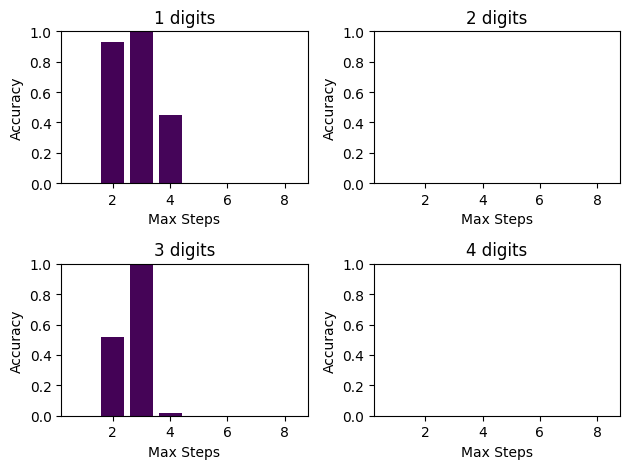

In [19]:
name = "Universal Transformer trained on 1-3 digits, 3 steps"
eval_name = "exp1_ut_1-3digits_3steps"
ckpt_path = (
    CHECKPOINTS_DIR / "addition-1-3-digit/universal_transformer_3_steps/model.ckpt"
)
digits_list = [1, 2, 3, 4]
max_steps_list = [1, 2, 3, 4, 5, 6, 7, 8]

res = evaluate_ut_steps(cfg, ckpt_path, digits_list, max_steps_list)

fig = plot_accuracies(res, 2, 2)
fig.suptitle(name)
fig.tight_layout()
fig.savefig(PLOTS_DIR / f"{eval_name}.png")

## Experiment 2: UT trained on 1-7 digits

In [20]:
cfg = get_exp_config("2/exp2_universal_transformer")

### 1 step

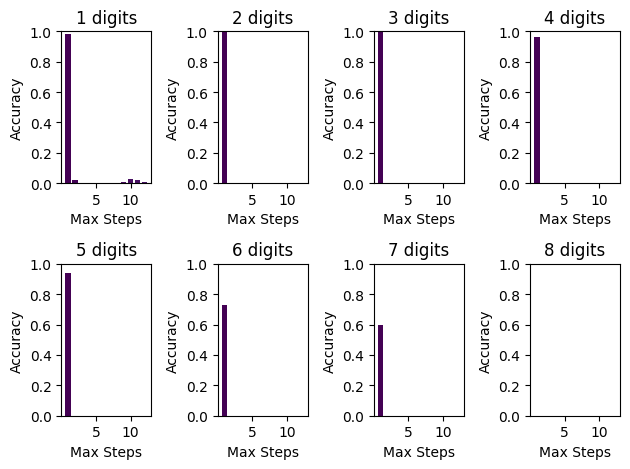

In [21]:
name = "Universal Transformer trained on 1-7 digits, 1 step"
eval_name = "exp2_ut_1-7digits_1step"
ckpt_path = (
    CHECKPOINTS_DIR / "addition-1-7-digit/universal_transformer_1step/model.ckpt"
)
digits_list = [1, 2, 3, 4, 5, 6, 7, 8]
max_steps_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

res = evaluate_ut_steps(cfg, ckpt_path, digits_list, max_steps_list)
fig = plot_accuracies(res, 4, 2)
fig.suptitle(name)
fig.tight_layout()
fig.savefig(PLOTS_DIR / f"{eval_name}.png")

### 3 steps

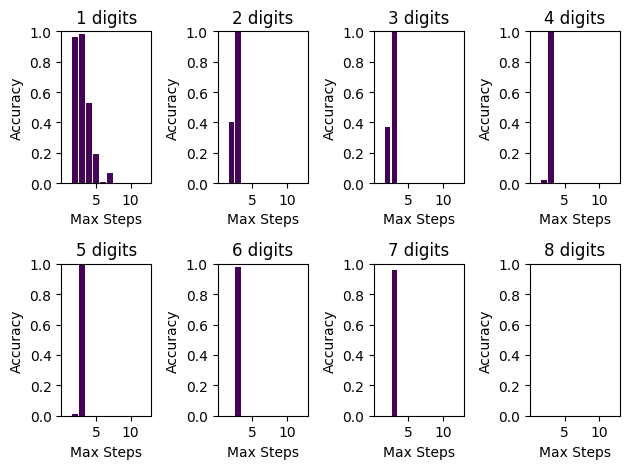

In [22]:
name = "Universal Transformer trained on 1-7 digits, 3 steps"
eval_name = "exp2_ut_1-7digits_3steps"
ckpt_path = (
    CHECKPOINTS_DIR / "addition-1-7-digit/universal_transformer_3_steps/model.ckpt"
)
digits_list = [1, 2, 3, 4, 5, 6, 7, 8]
max_steps_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

res = evaluate_ut_steps(cfg, ckpt_path, digits_list, max_steps_list)
fig = plot_accuracies(res, 4, 2)
fig.suptitle(name)
fig.tight_layout()
fig.savefig(PLOTS_DIR / f"{eval_name}.png")